<a href="https://colab.research.google.com/github/lakatosgabor/magyar_modszer/blob/main/Magyar_m%C3%B3dszer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import random


def get_operators():
  #itt kérdezem le a bent lévő opeártorokat
  operators = ["Gipsz Jakab", "Mona Lisa", "Teszt Elek"]
  return operators

def get_products():
  #itt kérdezem le, hogy mely termékeket kell gyártani
  #ha egy termék több operátoros az többször kerül be a listába
  products = ["A", "B", "C"]
  return products

def get_efficiency_matrix(operators, products):
  #itt kell lekérdezni az operátorok hatékonyságát az adott termékre
  EFFICIENCY = np.array([
    [200, 100, 100],
    [100, 100, 100],
    [200, 100, 100],
  ])

  EFFICIENCY = EFFICIENCY.astype(float)

  EFFICIENCY = to_square_matrix(EFFICIENCY)

  return EFFICIENCY

def to_square_matrix(matrix):
    rows, cols = matrix.shape
    if rows == cols:
        return matrix

    # Ha nem négyzetes, átalakítjuk
    n = max(rows, cols)
    square_matrix = np.zeros((n, n), dtype=matrix.dtype)
    square_matrix[:rows, :cols] = matrix
    return square_matrix

def get_monotony_matrix(operators, products):
  #ide jön a monotonítás lekérdezése

  monotony = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
  ])

  monotony = monotony.astype(float)

  return to_square_matrix(monotony)

def pertubation(EFFICIENCY):
    rows, cols = EFFICIENCY.shape
    for col in range(cols):
        for row in range(rows):
            # Alapérték átalakítás és kis véletlenszerű eltérés hozzáadása, egy megadott tartományban generál kis véletlen eltéréseket
            EFFICIENCY[row, col] = ((EFFICIENCY[row, col] // 3) * 3) + np.random.uniform(-0.5, 0.5)
    return EFFICIENCY

def to_constraints_matrix(operators, products, COST):
  #adatbázisból kérdezzül le
  constraints_matrix = np.array([
    [0, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
  ])

  constraints_matrix = constraints_matrix.astype(float)

  constraints_matrix = to_square_matrix(constraints_matrix)

  # Megkeressük az összes 0 értéket a constraints_matrix-ban
  zero_indices = np.where(constraints_matrix == 0)

  # Az azonos indexű elemeket a H mátrixban inf-re állítjuk
  COST[zero_indices] = 10000

  return COST

def cost_matrix(EFFICIENCY):
  max_value = np.max(EFFICIENCY)
  EFFICIENCY = max_value - EFFICIENCY

  return EFFICIENCY

def run_hungarian_algorithm(operators, products, COST):
  row_ind, col_ind = linear_sum_assignment(COST)
  assignments = [(operators[i], products[j]) for i, j in zip(row_ind, col_ind)]

  return assignments


############### RUN PROCESS ###############

operators = get_operators()

products = get_products()

EFFICIENCY = get_efficiency_matrix(operators, products)

MONOTONY = get_monotony_matrix(operators, products)

EFFICIENCY = EFFICIENCY * MONOTONY

EFFICIENCY = pertubation(EFFICIENCY)

COST = cost_matrix(EFFICIENCY)

COST = to_constraints_matrix(operators, products, COST)

assignments = run_hungarian_algorithm(operators, products, COST)
assignments

[('Gipsz Jakab', 'C'), ('Mona Lisa', 'B'), ('Teszt Elek', 'A')]

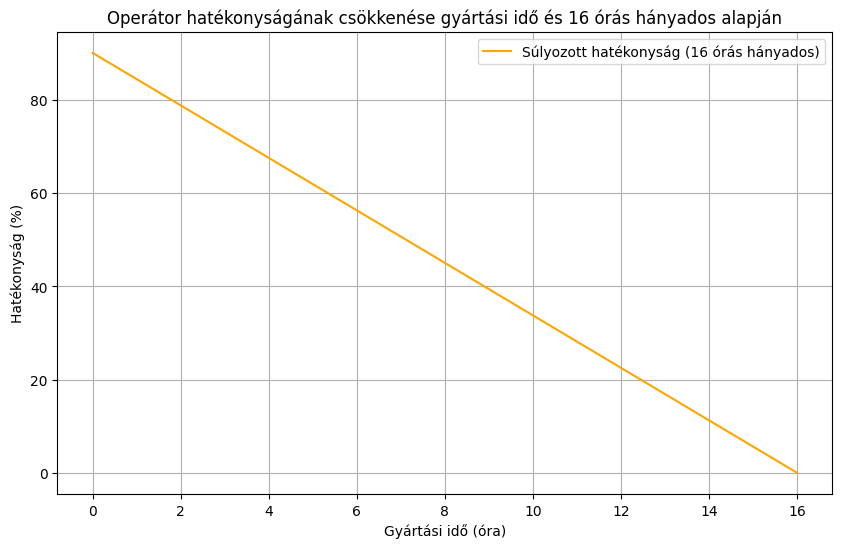

In [26]:
# Új megközelítés, ahol a gyártási idő hányadosát 16 órával súlyozzuk a hatékonyságra
def sulyozott_hatekonysag_hanyados(hatekonysag, t, max_ido=16):
    # A gyártási idő hányadosával csökkentjük a hatékonyságot
    hanyados = min(t / max_ido, 1)  # Ügyeljünk arra, hogy ne lépje túl az 1-et
    return hatekonysag * (1 - hanyados)

# Súlyozott hatékonyság kiszámítása minden időpontra az új hányados alapú képlettel
sulyozott_hatekonysag_hanyados_values = [sulyozott_hatekonysag_hanyados(kezdeti_hatekonysag, t) for t in gyartasi_ido]

# Grafikon készítése
plt.figure(figsize=(10, 6))
plt.plot(gyartasi_ido, sulyozott_hatekonysag_hanyados_values, label="Súlyozott hatékonyság (16 órás hányados)", color="orange")
plt.xlabel("Gyártási idő (óra)")
plt.ylabel("Hatékonyság (%)")
plt.title("Operátor hatékonyságának csökkenése gyártási idő és 16 órás hányados alapján")
plt.grid(True)
plt.legend()
plt.show()


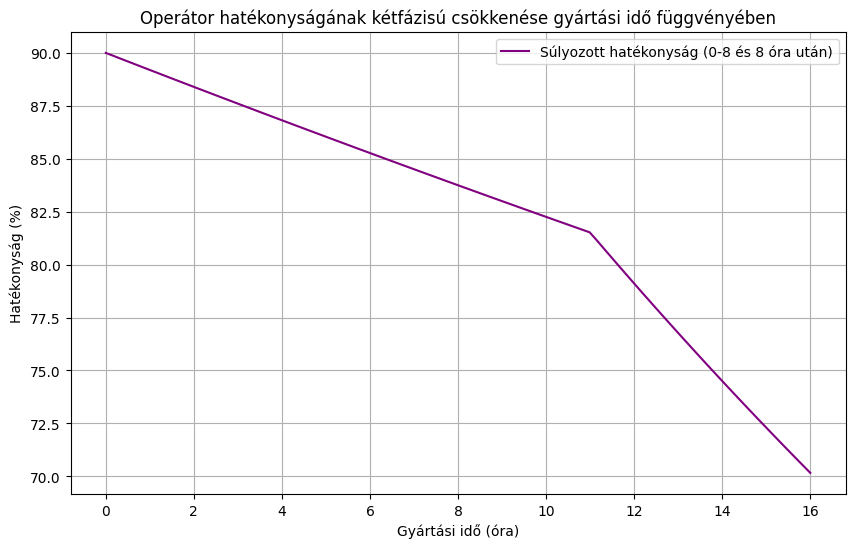

In [34]:
# Kétfázisú súlyozás beállítása: 0-8 óra között kisebb csökkenés, majd 8 óra után erősebb
def sulyozott_hatekonysag_ketfazisu(hatekonysag, t, lambd1=0.009, lambd2=0.03, threshold=11):
    # Kisebb csökkenés 0-8 óra között, erősebb csökkenés 8 óra után
    if t <= threshold:
        return hatekonysag * np.exp(-lambd1 * t)
    else:
        # Az első 8 órára alkalmazzuk a lambd1 szerinti csökkenést, majd 8 óra után lambd2-vel
        return hatekonysag * np.exp(-lambd1 * threshold) * np.exp(-lambd2 * (t - threshold))

# Súlyozott hatékonyság kiszámítása minden időpontra az új kétfázisú képlettel
sulyozott_hatekonysag_ketfazisu_values = [sulyozott_hatekonysag_ketfazisu(kezdeti_hatekonysag, t) for t in gyartasi_ido]

# Grafikon készítése
plt.figure(figsize=(10, 6))
plt.plot(gyartasi_ido, sulyozott_hatekonysag_ketfazisu_values, label="Súlyozott hatékonyság (0-8 és 8 óra után)", color="purple")
plt.xlabel("Gyártási idő (óra)")
plt.ylabel("Hatékonyság (%)")
plt.title("Operátor hatékonyságának kétfázisú csökkenése gyártási idő függvényében")
plt.grid(True)
plt.legend()
plt.show()
